In [1]:
import Numeric.Hamilton (stepHam, System, Phase (Phs, phsPositions, phsMomenta), mkSystem', Config (cfgPositions, cfgVelocities, Cfg), toPhase)
import GHC.TypeLits (KnownNat)
import Numeric.LinearAlgebra.Static hiding ((#))
import qualified Data.Vector.Sized                   as V
import Control.Monad.Bayes.Class
import Data.Maybe (fromMaybe)
import Control.Monad.Bayes.Sampler
import Control.Monad

:e PatternSynonyms
:e ViewPatterns
:e RankNTypes
:e DataKinds




In [74]:

pattern V1 :: a -> V.Vector 1 a
pattern V1 x <- (V.head->x)
  where
    V1 x = V.singleton x

type V2 = V.Vector 2
pattern V2 :: a -> a -> V2 a
pattern V2 x y <- (V.toList->[x,y])
  where
    V2 x y = V.fromTuple (x, y)



system :: System 1 1
system = 
    mkSystem' 1 
    id 
    (\(V1 x) -> x ** 2 / 2)
    -- mkSystem' (vec2 1 1                             )     -- masses
    --               (\(V1 θ)   -> V2 (sin θ) (0.5 - cos θ))     -- coordinates
    --               (\(V2 _ y) -> y                       )     -- potential

-- ex :: (KnownNat m, KnownNat n) => System
--   m n
--     -> Phase n
--     -> Phase n
step = sampleIO $ stepHam 0.1 system <$> phase  

-- a :: (R 1)
fromDouble :: Double -> (R 1)
fromDouble = fromList  . (:[])

phase :: MonadSample m => m (Phase 1)
phase = do
  pos <- (5*) <$> random
  return $ Phs {phsPositions = fromDouble pos, phsMomenta = 10}

Line 31: Redundant bracket
Found:
Double -> (R 1)
Why not:
Double -> R 1

In [75]:
toDouble :: R 1 -> Double 
toDouble = read . take 8 . tail . show

In [76]:
import Data.List

pushforward = do
    old <- phase
    let new = [stepHam stepSize system old | stepSize <- [0.1,0.2..10]]
    
    return ( (toDouble . phsPositions) <$> (old:new) )
    
pairs <- sampleIO $ replicateM 10 pushforward

timeseries = transpose pairs

length $ head timeseries
 

10

In [77]:
import Diagrams.Prelude hiding (normal)
import Diagrams.Prelude (V2(..), (#))
import qualified Diagrams.Backend.Cairo as C

:e FlexibleContexts
:e GADTs

toD x = circle 1 # translateX x


:t [toD <$> x | x <- timeseries]
-- diag = 

[toD <$> x | x <- timeseries] :: forall {b}. (Transformable b, TrailLike b, V b ~ V2, N b ~ Double) => [[b]]

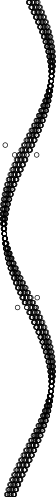

In [78]:
diagram $ vsep 0.1 $
    [mconcat $ toD <$> x | x <- timeseries]
    
    